In [1]:
import torch
import numpy as np
from src.datasets.uci_loader import UCIDataset
import seaborn as sns
from src.model_builder import build_model, sghmc_sampling, print_sample_performance, collect_samples, predict_y, compute_mnll, predict
from src.core.sampler import SGHMC_sampler
from torchviz import make_dot
%load_ext autoreload
%autoreload 2

# setting PyTorch

from src.misc.settings import settings
device = settings.device
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

 # Load regression UCI dataset

data_uci = UCIDataset(dataset_path='data/uci/boston.pth', static_split=True, seed=0)
N, D = data_uci.X_train.shape
print(f'X-train: {N, D}')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Loading dataset from data/uci/boston.pth


X-train: (393, 13)


How the model works in BGSP:
1. There is a `run_regression.py` file to setup the model classes such as `RegressionModel` and the cmd line arguments
2. The `RegressionModel` in `models.py` builds the `DGP` model and launches a training loop with the hmc sampling inside
3. The `DGP` class is defined throug different `Layers` and instantiates the TensorFlow session and does the initialization 

In [5]:
#  Instantiate a model
class ARGS():
    num_inducing = 100
    n_layers = 1
    minibatch_size = 100
    window_size = 64
    output_dim= 1
    adam_lr = 0.01
    prior_inducing_type = "uniform"
    full_cov = False
    epsilon = 0.01
    mdecay = 0.05
    iterations = 1024
    num_posterior_samples = 256
    posterior_sample_spacing = 32
args = ARGS()

bsgp_model = build_model(data_uci.X_train, data_uci.Y_train, args)
#make_dot(nll, params={'nll': nll}).render("computation_graph", format="png", cleanup=True)

In [10]:
bsgp_model.reset(data_uci.X_train, data_uci.Y_train)

sghmc_sampler = SGHMC_sampler(bsgp_model.parameters(), args.mdecay, args.epsilon)

sghmc_sampler.zero_grad()
X_batch, Y_batch = bsgp_model.get_minibatch()
nll = bsgp_model.forward(X_batch, Y_batch)
#make_dot(prior, params={'prior': prior}).render("computation_graph", format="png", cleanup=True)
#nll.backward(retain_graph=True)
#print([p for p in bsgp_model.parameters()][3]._grad)
grads = torch.autograd.grad(nll, bsgp_model.layers[0].kernel.lengthscales, retain_graph=True)
grads
#sghmc_sampler.step()

(tensor([0.0092, 0.0092, 0.0092, 0.0092, 0.0092, 0.0092, 0.0092, 0.0092, 0.0092,
         0.0092, 0.0092, 0.0092, 0.0092]),)

In [3]:
bsgp_model.reset(data_uci.X_train, data_uci.Y_train)
global_step = 0
for _ in range(args.iterations):
    bsgp_model.zero_grad()
    global_step += 1
    sample = sghmc_sampling(bsgp_model)
    """
    if args.prior_type == "determinantal":
        bsgp_model.reset_Lm()
        #model.train_hypers() if hasattr(self.model, 'hyper_train_op') else None
    """
    if _ % 50 == 1:
        marginal_ll = print_sample_performance(bsgp_model)
        print('TRAIN | iter = %6d      sample marginal LL = %5.2f' % (_, marginal_ll))
    
collect_samples(bsgp_model, args.num_posterior_samples, args.posterior_sample_spacing)

ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

<AxesSubplot: >

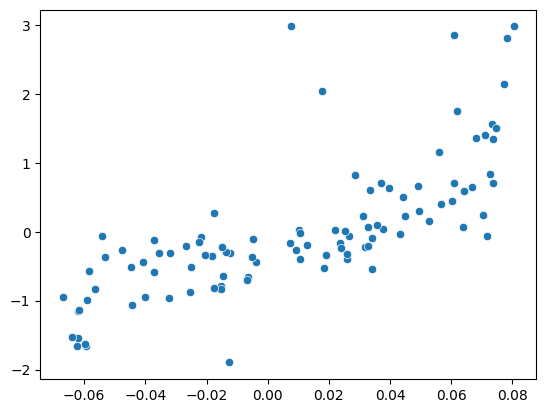

In [4]:
m = np.average(ms, 0)
v = np.average(vs + ms**2, 0) - m**2
sns.scatterplot(x=m.reshape(-1), y=data_uci.Y_test.reshape(-1))

In [5]:
ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')

Test MNLL = -3.514273795408619


/home/adm_kconstantin/Desktop/BSGP_Project/BSGPtorch/src/core/bsgp.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data.copy_(torch.tensor(value, dtype=torch.float64))
